In [155]:
import numpy as np
np.set_printoptions(precision=4)
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats import multivariate_normal as mvn
from scipy.special import iv
from scipy.ndimage import spline_filter, map_coordinates
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

In [156]:
def distribution(x, y, x0, y0, mu_theta, sigma, kappa):
    gaussian = np.exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))
    theta = np.arctan2(y - y0, x - x0)
    angular = np.exp(kappa * np.cos(theta - mu_theta))
    norm = 1 / (2 * np.pi * iv(0, kappa) * sigma**2)
    dist = gaussian * norm * angular
    return dist


In [157]:
L = [.5,.5] ### lower = 0 assumed
### Grid
N_orig = 64
x_orig = np.linspace(-L[0], L[0], N_orig)
y_orig = np.linspace(-L[1], L[1], N_orig)
X_orig, Y_orig = np.meshgrid(x_orig, y_orig)

### Params of precomputed distribution 
sigma = 0.1
kappa = 5.0

## Inital position
x0 = 0.0
y0 = 0.0
mu_theta = 0.0

In [158]:
###### Precompute ####
Z_original = distribution(X_orig, Y_orig, x0, y0, mu_theta, sigma, kappa)

### Zero padding change N > N_orig to add padding
N = N_orig
x = np.linspace(-L[0] * N / N_orig, L[0]* N / N_orig, N)
y = np.linspace(-L[1] * N / N_orig, L[1]* N / N_orig, N)
X, Y = np.meshgrid(x, y)
dx = x[1] - x[0]
dy = y[1] - y[0]
Z_padded = np.zeros((N, N))
idx_start = (N - N_orig) // 2
idx_end = idx_start + N_orig
Z_padded[idx_start:idx_end, idx_start:idx_end] = Z_original

# Apply fftshift in spatial domain
Z_shifted = np.fft.fftshift(Z_padded)

# Compute FFT with orthonormal normalization (divide by N)
F = np.fft.fft2(Z_shifted, norm='ortho')
F = np.fft.fftshift(F)  # Shift DC to center
freq_x = np.fft.fftshift(np.fft.fftfreq(N, dx))
freq_y = np.fft.fftshift(np.fft.fftfreq(N, dy))
Wx, Wy = np.meshgrid(freq_x, freq_y)
### dF/dk
dF_dkx = -1j * np.fft.fftshift(np.fft.fft2(X * Z_shifted, norm='ortho'))
dF_dky = -1j * np.fft.fftshift(np.fft.fft2(Y * Z_shifted, norm='ortho'))

def precompute_spline(F, dF_dkx, dF_dky, order=3):
    """
    Precompute spline coefficients ONCE.
    Returns the filtered arrays.
    """
    F_spline = spline_filter(F, order=order)
    dF_dkx_spline = spline_filter(dF_dkx, order=order)
    dF_dky_spline = spline_filter(dF_dky, order=order)
    return F_spline, dF_dkx_spline, dF_dky_spline
F, dF_dkx, dF_dky = precompute_spline(F, dF_dkx, dF_dky, order=5)


In this Code we did not estimate the Fourier $\hat{f}(k)$ but used interpolation and derived the Gradient w.r.t $\theta$ numerically. However, if speed is required estimate the function apriori (i.e by a Neural Network) and then compute as described in the paper.

In [159]:
def get_coeffs_spline(
    x, 
    F_spline, dF_dkx_spline, dF_dky_spline, 
    Wx, Wy, freq_x, freq_y, dx, dy, N, order=3
):
    """
    Fast evaluation using spline-filtered data.
    """
    theta = x[2]
    cos_alpha = np.cos(-theta)
    sin_alpha = np.sin(-theta)

    # 1. Rotate frequencies
    Wx_rot = Wx * cos_alpha - Wy * sin_alpha
    Wy_rot = Wx * sin_alpha + Wy * cos_alpha

    # 2. Map to index space for interpolation
    freq_x_map = (Wx_rot - freq_x[0]) / (freq_x[1] - freq_x[0])
    freq_y_map = (Wy_rot - freq_y[0]) / (freq_y[1] - freq_y[0])
    coords = np.array([freq_y_map, freq_x_map])

    # 3. Interpolate complex values (fast: prefiltered, prefilter=False)
    def interp(F_complex):
        F_real = np.real(F_complex)
        F_imag = np.imag(F_complex)
        real = map_coordinates(F_real, coords, order=order, prefilter=False, mode='reflect')
        imag = map_coordinates(F_imag, coords, order=order, prefilter=False, mode='reflect')
        return real + 1j * imag

    F_rot = interp(F_spline)
    dF_dkx_rot = interp(dF_dkx_spline)
    dF_dky_rot = interp(dF_dky_spline)

    F_rot = np.fft.ifftshift(F_rot)
    dF_dkx_rot = np.fft.ifftshift(dF_dkx_rot)
    dF_dky_rot = np.fft.ifftshift(dF_dky_rot)

    # 4. Exact translation in Fourier domain
    x0, y0 = x[0], x[1]
    kx = np.fft.fftfreq(N, d=dx)
    ky = np.fft.fftfreq(N, d=dy)
    kx_grid, ky_grid = np.meshgrid(kx, ky, indexing='ij')
    shift_factor = np.exp(-2j * np.pi * (kx_grid * x0 + ky_grid * y0))

    F_rot_shifted = F_rot * shift_factor
    dF_dx0 = -2j * np.pi * kx_grid * F_rot * shift_factor
    dF_dy0 = -2j * np.pi * ky_grid * F_rot * shift_factor

    # 5. Exact chain rule for rotation derivative
    dWx_dtheta = Wx * np.sin(-theta) + Wy * np.cos(-theta)
    dWy_dtheta = -Wx * np.cos(-theta) + Wy * np.sin(-theta)
    dF_dtheta = (dF_dkx_rot * dWx_dtheta + dF_dky_rot * dWy_dtheta) * shift_factor

    return F_rot_shifted, np.stack([dF_dx0, dF_dy0, dF_dtheta])



def get_coeffs_and_derivatives(x, F, dF_dkx, dF_dky, Wx, Wy, freq_x, freq_y, dx, dy, N):
    #F_rotated_shifted, dF_dx0, dF_dy0, dF_dtheta = get_coeffs(
    #    x, F, dF_dkx, dF_dky, Wx, Wy, freq_x, freq_y, dx, dy, N
    #)

    return get_coeffs_spline(
    x, 
    F, dF_dkx, dF_dky, 
    Wx, Wy, freq_x, freq_y, dx, dy, N, order=5
)

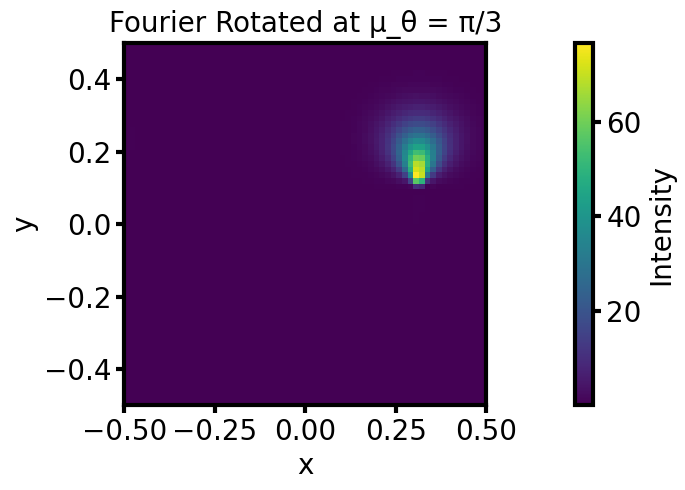

0.9998356546753882


In [160]:
x = np.array([0.1,0.3, np.pi/2])
F_rotated,dF = get_coeffs_and_derivatives(x, F, dF_dkx, dF_dky, Wx, Wy, freq_x, freq_y, dx, dy, N)
Z_rotated_padded = np.fft.ifft2(F_rotated, norm = 'ortho')
Z_rotated_padded = np.abs(Z_rotated_padded)
Z_rotated = np.fft.ifftshift(Z_rotated_padded)
Z_rotated = Z_rotated[idx_start:idx_end, idx_start:idx_end]
fig, (ax2) = plt.subplots(1, 1, figsize=(18, 5))
im2 = ax2.imshow(Z_rotated, extent=[-0.5, 0.5, -0.5, 0.5], origin='lower', cmap='viridis')
ax2.set_title('Fourier Rotated at μ_θ = π/3')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
plt.colorbar(im2, ax=ax2, label='Intensity')
plt.tight_layout()
plt.show()
## Check valid pdf
print(Z_rotated.sum() * dx * dy)


In [161]:
# Define the target measure
mean1 = np.array([-.15, -.12])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.6

mean2 = np.array([0.18, -0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.06, 0.14])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])

w3 = 0.1

mean4 = np.array([-.28, 0.24])
cov4 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w4 = 0.1

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3) + \
           w4 * mvn.pdf(x, mean4, cov4)

In [162]:
###### Precompute ####
points = np.stack([X_orig.ravel(), Y_orig.ravel()], axis=-1)
Z_target = pdf(points).reshape((N_orig, N_orig))

### Zero padding
N = N_orig
x = np.linspace(-L[0] * N / N_orig, L[0]* N / N_orig, N)
y = np.linspace(-L[1]* N / N_orig, L[1]* N / N_orig, N)
X, Y = np.meshgrid(x, y)
dx = x[1] - x[0]
dy = y[1] - y[0]
Z_target_padded = np.zeros((N, N))
idx_start = (N - N_orig) // 2
idx_end = idx_start + N_orig
Z_target_padded[idx_start:idx_end, idx_start:idx_end] = Z_target

# Apply fftshift in spatial domain
Z_target_shifted = np.fft.fftshift(Z_target_padded)

# Compute FFT with orthonormal normalization (divide by N)
F_target = np.fft.fft2(Z_target_shifted, norm='ortho')
F_target *= N * dx * dy

In [163]:
### Both should be roughly 1
print(F_target[0,0], F_rotated[0,0] * N * dx * dy)

(0.9983509569056762+0j) (0.9952149751081896+1.8382487914494115e-16j)


In [164]:
### Weights of respective Fourier coefficients
s = -1.5  # Sobolev order
kx = np.fft.fftfreq(N, d=dx)
ky = np.fft.fftfreq(N, d=dy)
kx_grid, ky_grid = np.meshgrid(kx, ky, indexing='ij')
k_squared = kx_grid**2 + ky_grid**2
lamk_list = (1 + (2 * np.pi)**2 * k_squared)**s

In [165]:
dt = 0.01
tsteps = 20001
ud = .2 # max desired linear velocity
u_omega = np.pi # desired max angular velocity

def dyn(xt, ut):
    x, y, theta = xt
    v, omega = ut
    return np.array([
        v * np.cos(theta),
        v * np.sin(theta),
        omega
    ])

def step(xt, ut):
    return xt + dt * dyn(xt, ut)
# Initialize state [x, y, theta]
xt = np.array([np.random.uniform(-0.5, 0.5), np.random.uniform(-0.5, 0.5), np.random.uniform(-np.pi, np.pi)])
x_traj = np.zeros((tsteps, 3))
ck_list_update = np.zeros_like(F_target, dtype=np.float64)
ck_list_update_imag = np.zeros_like(F_target, dtype=np.float64)
metric_log = []    
barrier_weight = 0.0

for t in range(tsteps):
    xt = xt.real
    fk_xt_all, dfk_xt_all = get_coeffs_and_derivatives(xt, F, dF_dkx, dF_dky, Wx, Wy, freq_x, freq_y, dx, dy, N)

    fk_xt_all *= N * dx * dy # Normalize
    dfk_xt_all *= N * dx * dy # Normalize
    theta = xt[2]
    
    # Accumulate coefficients over time
    ck_list_update += fk_xt_all.real * dt
    ck_list_update_imag += fk_xt_all.imag * dt

    # Compute numerator for gradient step
    numerator = (ck_list_update / (t * dt + dt)) - F_target.real
    numerator_imag = (ck_list_update_imag / (t * dt + dt)) - F_target.imag

    # Compute weighted sum of numerator * gradient
    bt = np.sum(lamk_list * numerator * dfk_xt_all.real, axis=(1, 2))
    bt_imag = np.sum(lamk_list * numerator_imag * dfk_xt_all.imag, axis=(1, 2))


    # Combine real and imaginary parts to get gradient components
    b_tilde_real = np.array([
        bt[0] * np.cos(theta) + bt[1] * np.sin(theta),
        bt[2]
    ])
    b_tilde_imag = np.array([
        bt_imag[0] * np.cos(theta) + bt_imag[1] * np.sin(theta),
        bt_imag[2]
    ])

    b_tilde =  b_tilde_real + b_tilde_imag
    norm_b_tilde = np.linalg.norm(b_tilde)

    if norm_b_tilde < 1e-8:
        ut = np.array([0.0, 0.0])
    else:
        matrix = np.array([[-ud, 0], [0, -u_omega]])
        b_unit = b_tilde / norm_b_tilde
        v, omega = matrix @ b_unit
        v = np.clip(v, -ud, ud)
        omega = np.clip(omega, -u_omega, u_omega)
        ut = np.array([v, omega])

    xt = step(xt, ut)
    x_traj[t] = xt.copy()

    ### Problems with perodicity of Fourier transform under unicycle model! For the Spherical sets we defined a barrier function cf. Simulation\notebooks\smc_ergodic_unicycle.ipynb
    xt[0] = (xt[0] + 0.5) % 1 - 0.5
    xt[1] = (xt[1] + 0.5) % 1 - 0.5

    # Calculate ergodic metric error (use full complex parts)
    err_real = np.square(F_target.real - ck_list_update / (t * dt + dt))
    err_imag = np.square((F_target.imag - ck_list_update_imag) / (t * dt + dt))
    erg_metric_real = np.sum(err_real)
    erg_metric_imag = np.sum(err_imag)
    metric_log.append(erg_metric_real + 1j* erg_metric_imag)
    if t % 1000 == 0:
        print(f"Step {t}, Position: {xt[:2].real}, Heading: {xt[2].real:.3f}, Metric real: {erg_metric_real:.5f}, Metric imag: {erg_metric_imag:.5f}")


Step 0, Position: [0.4318 0.0555], Heading: 1.486, Metric real: 19.32710, Metric imag: 14765.13229
Step 1000, Position: [-0.4374 -0.2294], Heading: 1.678, Metric real: 4.01475, Metric imag: 1.09750
Step 2000, Position: [-0.2979 -0.2084], Heading: 1.672, Metric real: 2.74940, Metric imag: 1.37586
Step 3000, Position: [-0.2481 -0.1522], Heading: 1.582, Metric real: 1.72298, Metric imag: 1.75216
Step 4000, Position: [-0.1886 -0.2854], Heading: 1.676, Metric real: 0.96859, Metric imag: 1.98566
Step 5000, Position: [0.132  0.2331], Heading: 3.133, Metric real: 0.73314, Metric imag: 1.28860
Step 6000, Position: [0.1828 0.1443], Heading: 3.107, Metric real: 0.61718, Metric imag: 0.70198
Step 7000, Position: [-0.143   0.0635], Heading: 3.359, Metric real: 0.64750, Metric imag: 0.55347
Step 8000, Position: [-0.1012 -0.0121], Heading: 3.159, Metric real: 0.67542, Metric imag: 0.52519
Step 9000, Position: [ 0.2959 -0.0551], Heading: 3.110, Metric real: 0.63713, Metric imag: 0.69584
Step 10000, Po

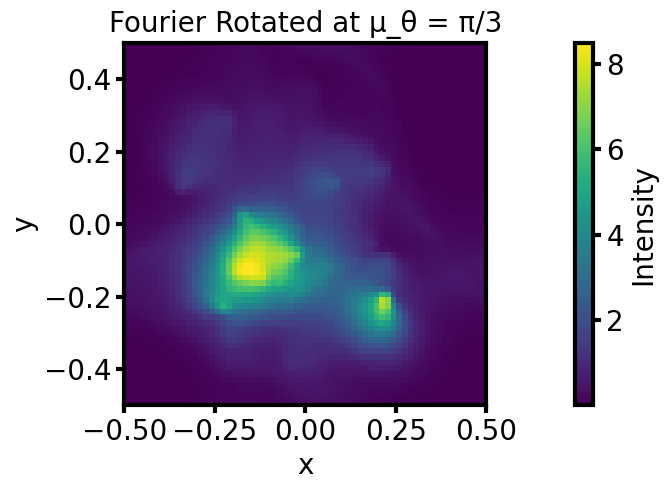

1.02707439055669


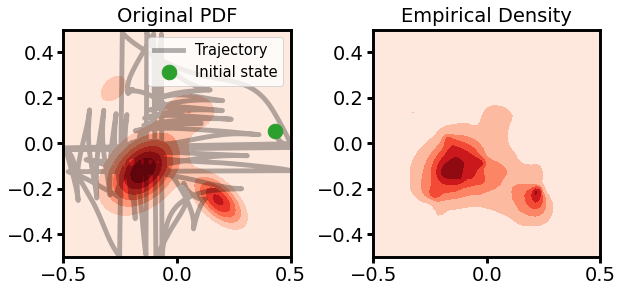

In [166]:
#### Plot the results
coeffs = (ck_list_update  + 1j * ck_list_update_imag) / (tsteps * dt)
Z_rotated_padded = np.fft.ifft2(coeffs, norm = 'forward')
Z_rotated_padded = np.abs(Z_rotated_padded)
Z_rotated = np.fft.ifftshift(Z_rotated_padded)
Z_rotated = Z_rotated[idx_start:idx_end, idx_start:idx_end]
fig, (ax2) = plt.subplots(1, 1, figsize=(18, 5))
im2 = ax2.imshow(Z_rotated, extent=[-0.5, 0.5, -0.5, 0.5], origin='lower', cmap='viridis')
ax2.set_title('Fourier Rotated at μ_θ = π/3')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
plt.colorbar(im2, ax=ax2, label='Intensity')
plt.tight_layout()
plt.show()
## Check valid pdf
print(Z_rotated.sum() * dx * dy)
fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)
ax = axes[0]
ax.set_aspect('equal')
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_title(f'Original PDF')
ax.contourf(X_orig, Y_orig, Z_target.reshape(X_orig.shape), cmap='Reds')
ax.plot(x_traj[::10, 0], x_traj[::10, 1], linestyle='-', marker='', color='k', alpha=0.3, label='Trajectory')
ax.plot(x_traj[0, 0], x_traj[0, 1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc='upper right')

ax2 = axes[1]
ax2.set_aspect('equal')
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax2.set_title(f'Empirical Density')
ax2.contourf(X_orig, Y_orig,
             Z_rotated.reshape(X_orig.shape),
             cmap='Reds')
plt.tight_layout()
plt.show()

In [ ]:
# Generate animation (takes about 1 minute)
from IPython.display import HTML
from matplotlib import animation

fig, ax = plt.subplots(1, 1, figsize=(6,7), dpi=70, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(-.5, .5)
ax.set_ylim(-.5, .5)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.contourf(X_orig, Y_orig, Z_target.reshape(X_orig.shape), cmap='Reds')

robot_traj, = ax.plot([], [], linestyle='-', marker='', color='k', alpha=0.2)
robot_state, = ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2')

def update_plot(frame):
    t = int(frame * 10)
    robot_state.set_data(
        np.array([x_traj[t][0]]), np.array([x_traj[t][1]])
    )
    robot_traj.set_data(
        x_traj[:t,0][::10], x_traj[:t,1][::10]
    )

    return robot_state, robot_traj,

ani = animation.FuncAnimation(fig, update_plot, frames=int(tsteps/10)-1, blit=True, interval=30, repeat=False)
video = ani.to_html5_video()
HTML(video)